In [1]:
import networkx as nx
import numpy as np
import random
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib import colors

In [2]:
class RandomWeightedGraph(nx.Graph):
    def __init__(self, nodes:int):
        super().__init__(nx.bipartite.random_graph(nodes, nodes, 0.5).edges())
        for (u, v) in self.edges():
            self.edges[u,v]['weight'] = np.random.randint(0,8)
            
    def weight(self, edge):
        return self.edges[edge]['weight']

In [15]:
class MinimumSpanningTree(list):
    def __init__(self, G: nx.Graph, root: int, describe: bool = False):
        self._original_G, self._G, self._root = G.copy(), G, root
        if describe:
            self._setup_describe()

    def _setup_describe(self):
        self._pos = nx.kamada_kawai_layout(self._G)
        gray, self._dark_gray = '#eeeeee', '#555555'
        self._node_colors = [gray for n in self._G]
        self._edge_colors = [gray for e in self._G.edges]
        positions = np.array(list(self._pos.values()))
        self._min_x, self._min_y = np.min(positions, axis=0) - 0.1
        self._max_x, self._max_y = np.max(positions, axis=0) + 0.1

    def _plot_graphs(self, graphs: list, title: str):
        n, graph_size, graph_per_row = len(graphs) + 1, 4, 4
        w, h = min(n, graph_per_row), np.ceil(n / graph_per_row)
        plt.figure(figsize=(graph_size * w, graph_size * h))
        plt.suptitle(title)
        for i, ((G, title), color) in enumerate(
                zip(graphs, ['r', 'c', 'm', 'pink', 'orange', 'b', 'g', 'y'])):
            ax = plt.subplot(h, w, i + 1)
            ax.set_xlim(self._min_x, self._max_x)
            ax.set_ylim(self._min_y, self._max_y)
            ax.set_title(title)
            nx.draw(
                self._original_G,
                pos=self._pos,
                with_labels=True,
                font_color="#999999",
                edge_labels=nx.get_edge_attributes(self._original_G, 'weight'),
                node_color=self._node_colors,
                edge_color=self._edge_colors)
            nx.draw(
                G,
                pos=self._pos,
                with_labels=True,
                font_color="#222222",
                node_color=color,
                edge_color=color)
            nx.draw_networkx_edge_labels(
                self._original_G,
                pos=self._pos,
                font_color="#777777",
                edge_labels=nx.get_edge_attributes(self._original_G, 'weight'))

        ax = plt.subplot(h, w, i + 2)
        ax.set_xlim(self._min_x, self._max_x)
        ax.set_ylim(self._min_y, self._max_y)
        ax.set_title("All Components")
        nx.draw(
            self._original_G,
            pos=self._pos,
            with_labels=True,
            font_color="#999999",
            edge_labels=nx.get_edge_attributes(self._original_G, 'weight'),
            node_color=self._node_colors,
            edge_color=self._edge_colors)

        for (G, title), color in zip(
                graphs, ['r', 'b', 'c', 'm', 'g', 'y', 'pink', 'orange']):
            nx.draw(
                G,
                pos=self._pos,
                with_labels=True,
                font_color="#222222",
                node_color=color,
                edge_color=color)

        nx.draw_networkx_edge_labels(
            self._original_G,
            pos=self._pos,
            font_color="#777777",
            edge_labels=nx.get_edge_attributes(self._original_G, 'weight'))

        plt.show()

    def _describe_start(self, root: int):
        tree = nx.Graph()
        tree.add_node(root)
        colors = ['r' for n in self._original_G]
        self._plot_graphs([(self._original_G, colors, "Initial Graph"),
                           (tree, colors, "Initial Tree")],
                          "Initial Conditions")

In [16]:
class KruskalTree(MinimumSpanningTree):
    def __init__(self, G: nx.Graph, root: int, describe: bool = False):
        super().__init__(G, root, describe=describe)
        [self.append([(v, v)]) for v in G]
        weights = nx.get_edge_attributes(G, 'weight')
        edges = sorted(weights, key=weights.get, reverse=True)
        i = 0
        if describe:
            self._plot_graphs(
                [(nx.Graph(c), "Component {c}".format(c=c)) for c in self],
                "Initial conditions".format(i=i))
        while not self._is_spanning():
            edge = u, v = edges.pop()
            set_u = self._get_node_component(u)
            set_v = self._get_node_component(v)
            if set_u != set_v:
                self[set_u] += self[set_v] + [(u, v)]
                del self[set_v]

            if describe:
                self._plot_graphs(
                    [(nx.Graph(c), "Component {j}".format(j=j))
                     for j, c in enumerate(self)],
                    "Iteration {i}: Merging component {u} with component {v} via edge ({a}, {b})"
                .format(
                    i=i, u=set_u, v=set_v, a=u, b=v))
            i += 1

    def _get_node_component(self, node: int):
        for i, component in enumerate(self):
            for edge in component:
                if node in edge:
                    return i
        return None

    def _is_spanning(self):
        return len(self) == 1

    def _create_iteration_graph(self, costs: dict, neighbors: list,
                                node: int) -> tuple:
        iteration = nx.Graph()
        [iteration.add_node(v) for v in [*costs, node, *neighbors]]
        colors = [
            'g' if v in neighbors else 'm' if v == node else 'c'
            for v in iteration
        ]
        return iteration, colors

In [17]:
random.seed(32)
np.random.seed(23)
G = RandomWeightedGraph(4)
root = 1

/anaconda3/lib/python3.6/site-packages/networkx/drawing/layout.py:610: RuntimeWarning: divide by zero encountered in true_divide
  costargs = (np, 1 / (dist_mtx + np.eye(dist_mtx.shape[0]) * 1e-3),


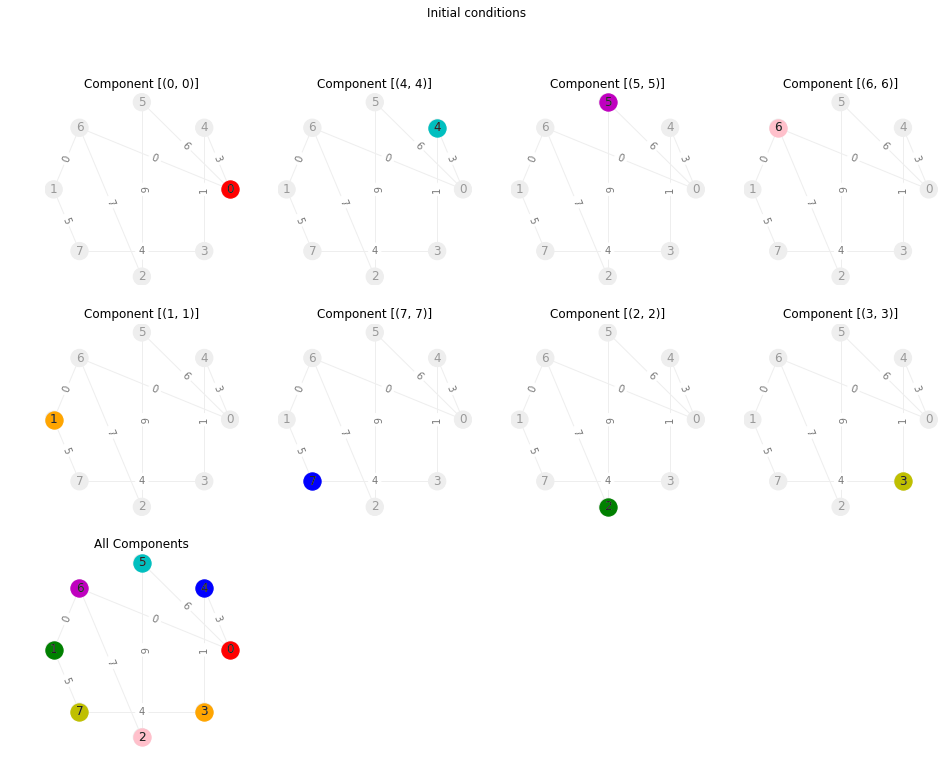

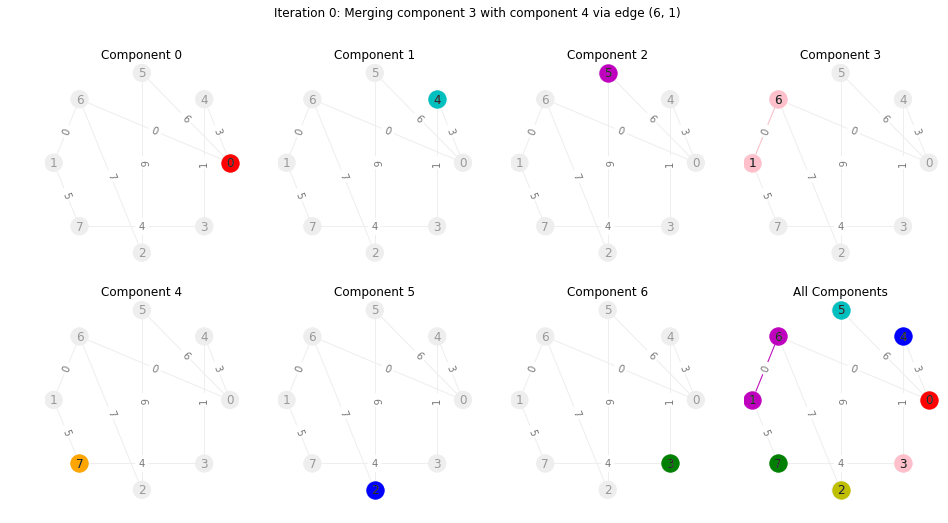

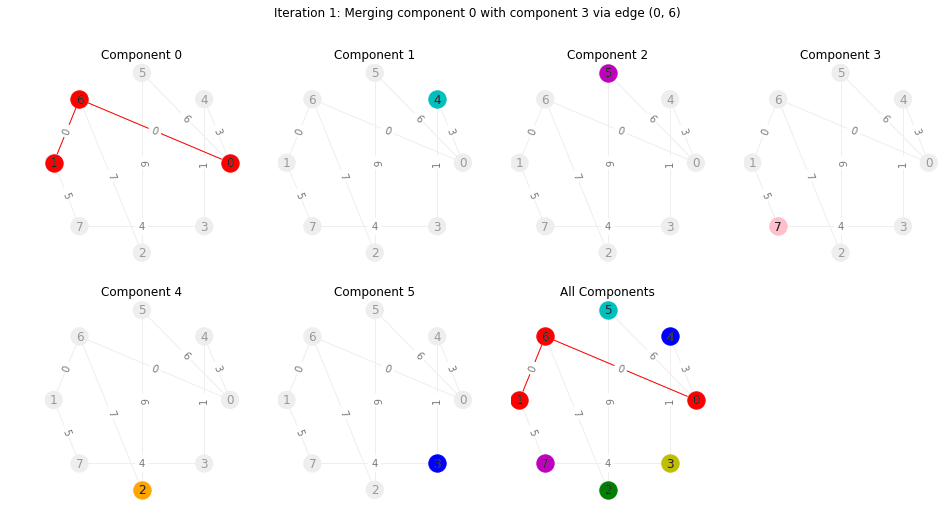

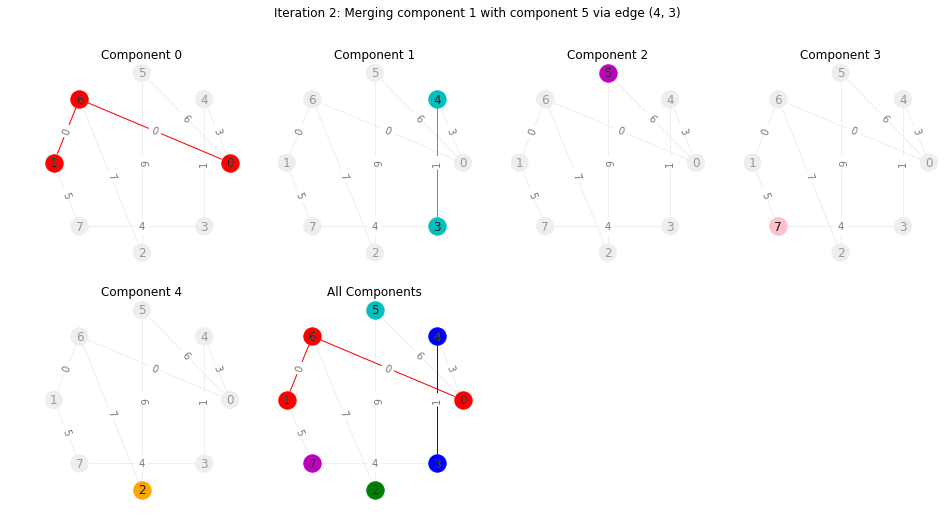

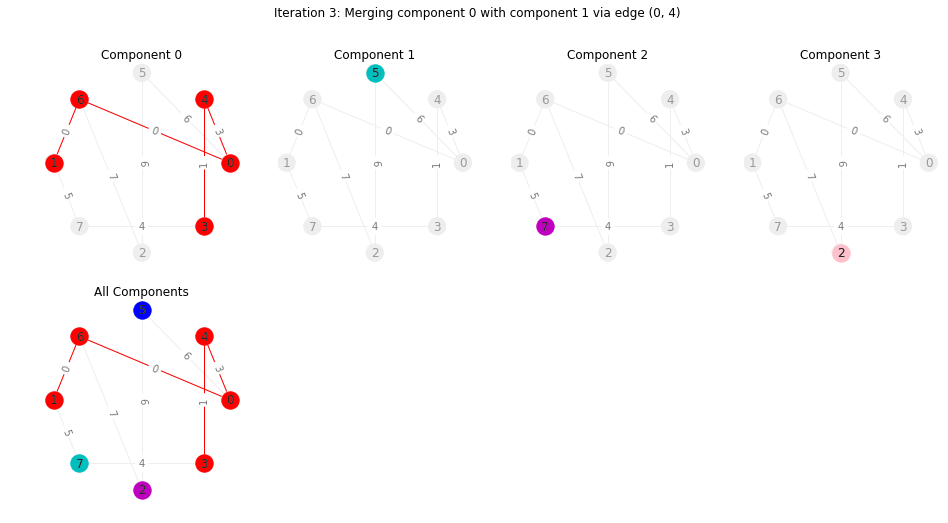

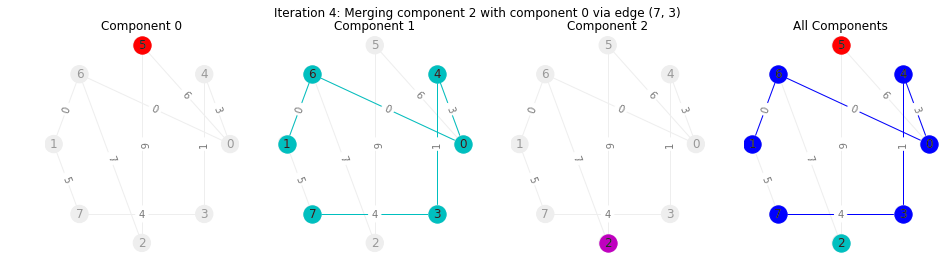

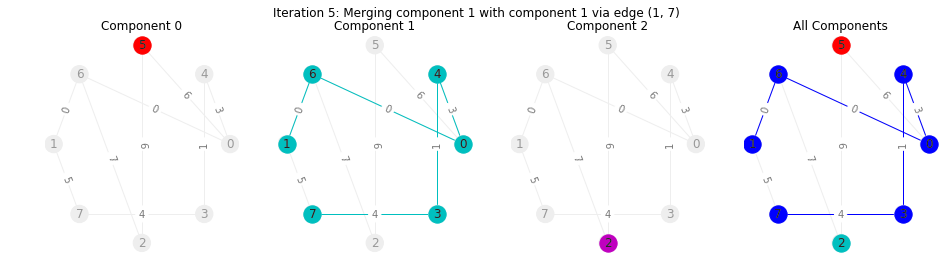

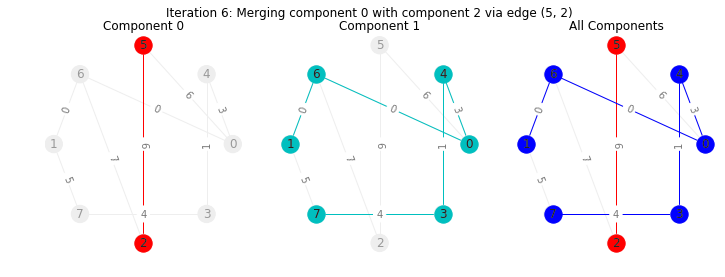

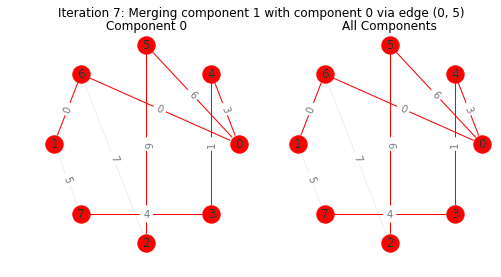

[[(7, 7),
  (0, 0),
  (6, 6),
  (1, 1),
  (6, 1),
  (0, 6),
  (4, 4),
  (3, 3),
  (4, 3),
  (0, 4),
  (7, 3),
  (5, 5),
  (2, 2),
  (5, 2),
  (0, 5)]]

In [18]:
KruskalTree(G, root, describe=True)